#Data Preprocessing

##Libraries Used

In [25]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import numpy as np
from tabulate import tabulate  # Using it for the recommendation outputs "to be in a table"

In [26]:
!unzip "/content/Books.csv.zip"
!unzip "/content/Ratings.csv.zip"
!unzip "/content/Users.csv.zip"

Archive:  /content/Books.csv.zip
  inflating: Books.csv               
Archive:  /content/Ratings.csv.zip
  inflating: Ratings.csv             
Archive:  /content/Users.csv.zip
  inflating: Users.csv               


In [27]:
# Load datasets
books = pd.read_csv("/content/Books.csv")
ratings = pd.read_csv("/content/Ratings.csv")
users = pd.read_csv("/content/Users.csv")

<ipython-input-27-904492a60b1b>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("/content/Books.csv")


##Viewing Data

In [28]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [29]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [30]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


##Preprocessing

In [31]:
# Drop 'Year-Of-Publication' column due to mixed types
books = books.drop(columns=['Year-Of-Publication'])

In [32]:
# Reduce dataset size for memory efficiency
books = books.sample(frac=0.1, random_state=42)  # Use a 10% sample of books
top_users = ratings['User-ID'].value_counts().head(5000).index  # Top 5000 users by ratings
ratings = ratings[ratings['User-ID'].isin(top_users)]  # Filter ratings for top users
ratings = ratings[ratings['ISBN'].isin(books['ISBN'])]  # Ensure ISBNs align with reduced books dataset

In [33]:
# Preprocessing
books['combined_features'] = (books['Book-Title'].fillna('') + ' ' +
                              books['Book-Author'].fillna(''))

#Building Algorithms

##Collaborative Filtering Algorithm

In [34]:
# Collaborative Filtering
# Creating user-item interaction matrix
user_item_matrix = ratings.pivot(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)
user_item_matrix = user_item_matrix.astype(np.float32)  # Reduce memory usage
user_item_sparse = csr_matrix(user_item_matrix)

In [35]:
# KNN model for Collaborative Filtering
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [36]:
def collaborative_filtering(user_id, n_recommendations=5):
    user_idx = user_item_matrix.index.get_loc(user_id)
    distances, indices = knn.kneighbors(user_item_sparse[user_idx], n_neighbors=n_recommendations+1)
    recommended_books = user_item_matrix.columns[indices.flatten()[1:]]
    return books[books['ISBN'].isin(recommended_books)]

##Content-Based Filtering Algorithm

In [37]:
# Content-Based Filtering
# TF-IDF vectorizer on book titles and authors with memory efficiency
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit features to reduce memory

# Recalculate cosine_sim after reducing books DataFrame
book_features_matrix = vectorizer.fit_transform(books['combined_features'])
cosine_sim = cosine_similarity(book_features_matrix, book_features_matrix)

In [38]:
# Content-Based Recommendation function
def content_based_filtering(book_isbn, n_recommendations=5):
    if book_isbn not in books['ISBN'].values:
        print(f"ISBN {book_isbn} not found in the dataset.")
        return None
    # Get the index of the book within the current books DataFrame
    idx = books.index[books['ISBN'] == book_isbn][0]

    # Map the index to the reduced DataFrame's index
    idx = books.index.get_loc(idx)

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n_recommendations+1]
    book_indices = [i[0] for i in sim_scores]
    return books.iloc[book_indices]

##Hybrid Approach Algorithm

In [39]:
# Hybrid Approach
def hybrid_recommendation(user_id, book_isbn, n_recommendations=5):
    collab_recs = collaborative_filtering(user_id, n_recommendations)
    content_recs = content_based_filtering(book_isbn, n_recommendations)

    # Handle the case where content_recs is None
    if content_recs is None:
        return collab_recs

    hybrid_recs = pd.concat([collab_recs, content_recs]).drop_duplicates().head(n_recommendations)
    return hybrid_recs

##Knowledge Based Algorithm

In [40]:
# Knowledge-Based Recommendations
def knowledge_based_recommendation(author=None, publisher=None, n_recommendations=5):
    filtered_books = books
    if author:
        filtered_books = filtered_books[filtered_books['Book-Author'].str.contains(author, na=False)]
    if publisher:
        filtered_books = filtered_books[filtered_books['Publisher'].str.contains(publisher, na=False)]
    return filtered_books.head(n_recommendations)

#Recommendation System Output

In [41]:
# Ensure the user_id exists in the reduced dataset
example_user_id = user_item_matrix.index[0]  # Use the first available User-ID
example_book_isbn = books.sample(1)['ISBN'].values[0]  # Pick a random ISBN from the reduced dataset

In [42]:
# Display all columns and more rows for collaborative filtering
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 10)  # Show more rows (adjust as needed)

##Collaborative Filtering Recommendations

In [43]:
print("Collaborative Filtering Recommendations:")
print(tabulate(collaborative_filtering(user_id=example_user_id), headers='keys', tablefmt='psql'))

Collaborative Filtering Recommendations:
+--------+------------+----------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-----------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|        |       ISBN | Book-Title                                                                                                                                   | Book-Author       | Publisher             | Image-URL-S                                                  | Image-URL-M                                                  | Image-URL-L                                                  | comb

##Content-Based Recommendations

In [46]:
print("Content-Based Recommendations:")
print(tabulate(content_based_filtering(book_isbn=example_book_isbn), headers='keys', tablefmt='psql'))

Content-Based Recommendations:
+--------+------------+-------------------------------------------------------+------------------+------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------------+
|        | ISBN       | Book-Title                                            | Book-Author      | Publisher        | Image-URL-S                                                  | Image-URL-M                                                  | Image-URL-L                                                  | combined_features                                                    |
|--------+------------+-------------------------------------------------------+------------------+------------------+--------------------------------------------------------------+---------------------------------

##Hybrid Recommendations

In [47]:
print("Hybrid Recommendations:")
print(tabulate(hybrid_recommendation(user_id=example_user_id, book_isbn=example_book_isbn), headers='keys', tablefmt='psql'))

Hybrid Recommendations:
+--------+------------+----------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-----------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|        |       ISBN | Book-Title                                                                                                                                   | Book-Author       | Publisher             | Image-URL-S                                                  | Image-URL-M                                                  | Image-URL-L                                                  | combined_features    

##Knowledge-Based Recommendations

In [48]:
print("Knowledge-Based Recommendations:")
print(tabulate(knowledge_based_recommendation(author="Bruce W. Talamon"), headers='keys', tablefmt='psql'))

Knowledge-Based Recommendations:
+--------+------------+---------------------------+------------------+---------------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------+
|        |       ISBN | Book-Title                | Book-Author      | Publisher                 | Image-URL-S                                                  | Image-URL-M                                                  | Image-URL-L                                                  | combined_features                          |
|--------+------------+---------------------------+------------------+---------------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------

#Visualizations

##Libraries Used

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

##Book Ratings Distribution

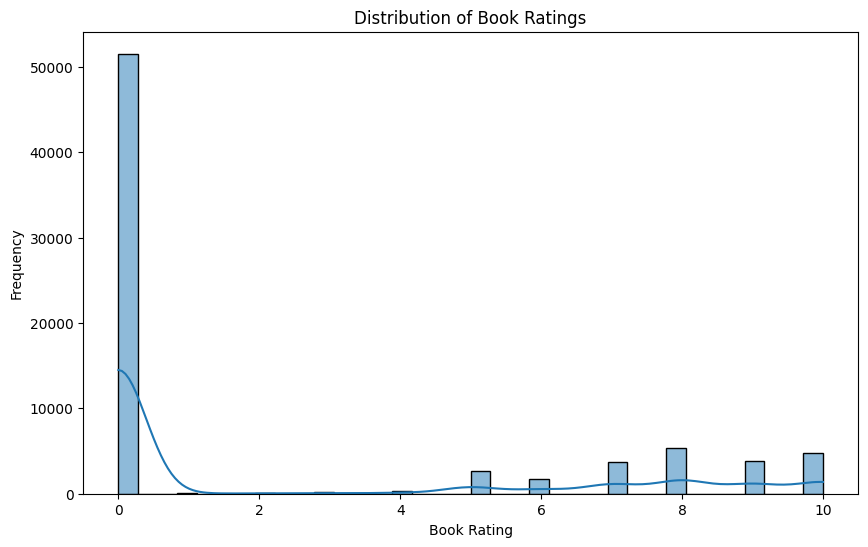

In [53]:
# Visualize book ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(ratings['Book-Rating'], kde=True)
plt.title('Distribution of Book Ratings')
plt.xlabel('Book Rating')
plt.ylabel('Frequency')
plt.show()

##Top 10 Authors

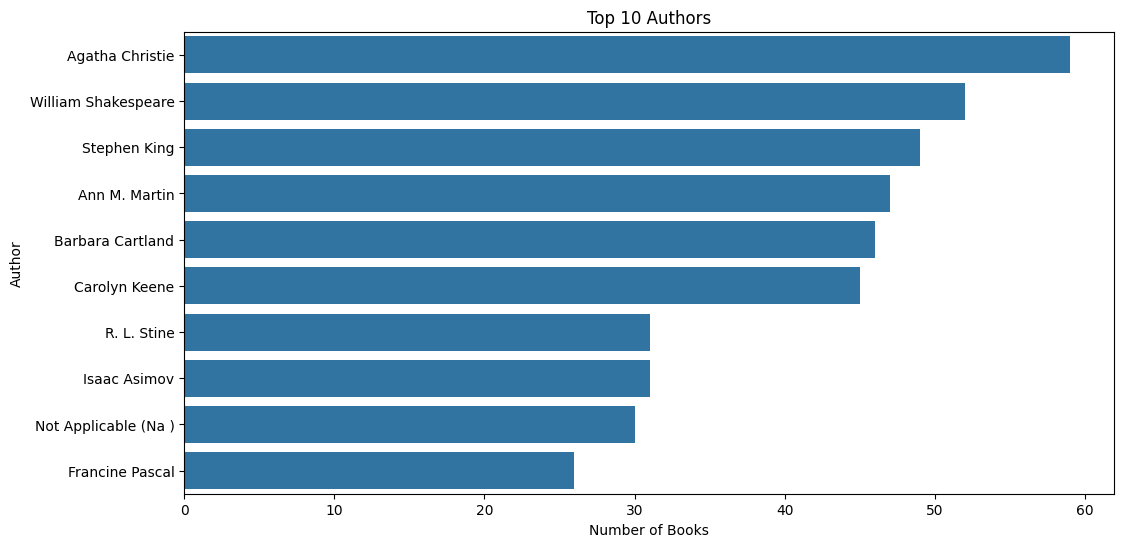

In [50]:
# Visualize top authors
top_authors = books['Book-Author'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_authors.values, y=top_authors.index)
plt.title('Top 10 Authors')
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.show()

##Top 10 Publishers

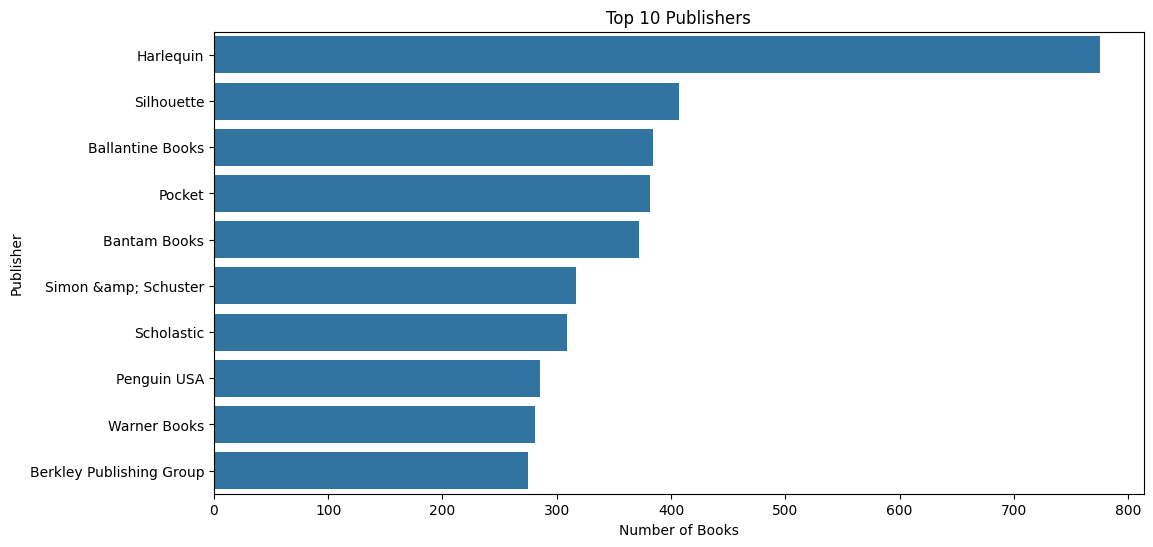

In [51]:
# Visualize top publishers
top_publishers = books['Publisher'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title('Top 10 Publishers')
plt.xlabel('Number of Books')
plt.ylabel('Publisher')
plt.show()

##Average Rating Per Book

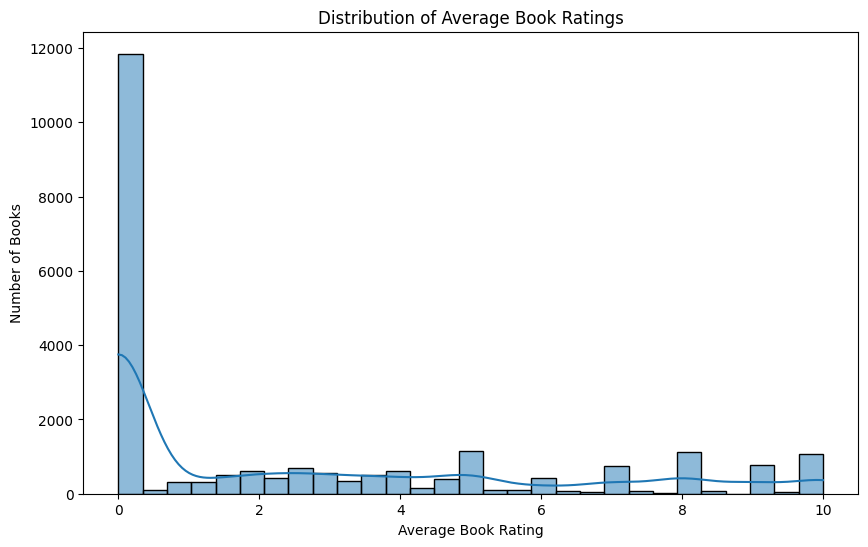

In [55]:
# Visualize average rating per book
average_ratings = ratings.groupby('ISBN')['Book-Rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(average_ratings, kde=True)
plt.title('Distribution of Average Book Ratings')
plt.xlabel('Average Book Rating')
plt.ylabel('Number of Books')
plt.show()